In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import scipy.io as sio
from matplotlib import pyplot

#Removed Depreciated tf method
#from tensorflow.keras.layers.experimental import preprocessing

from tensorflow.keras import layers
from keras.models import load_model
from tensorflow.keras import models
from tensorflow import keras
import pandas as pd

from keras.callbacks import EarlyStopping, ModelCheckpoint
from IPython import display

#To include from Google Drive
from google.colab import drive
#Mounting to google drive
drive.mount('/content/drive')

MODELS_DIR = '/content/drive/MyDrive/ENEE719D/Assignment1/models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model.keras'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'


Mounted at /content/drive


In [3]:
def predict_tflite(tflite_model, x_test):
  # Prepare the test data
  x_test_ = x_test.copy()
  #x_test_ = x_test_.reshape((x_test.size, 1))
  x_test_ = x_test_.astype(np.float32)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # If required, quantize the input layer (from float to integer)
  input_scale, input_zero_point = input_details["quantization"]
  if (input_scale, input_zero_point) != (0.0, 0):
    x_test_ = x_test_ / input_scale + input_zero_point
    x_test_ = x_test_.astype(input_details["dtype"])
  # Invoke the interpreter
  interpreter.set_tensor(input_details["index"], x_test_)
  interpreter.invoke()
  y_pred = interpreter.get_tensor(output_details["index"])[0]

  # If required, dequantized the output layer (from integer to float)
  output_scale, output_zero_point = output_details["quantization"]
  if (output_scale, output_zero_point) != (0.0, 0):
    y_pred = y_pred.astype(np.float32)
    y_pred = (y_pred - output_zero_point) * output_scale

  return y_pred


#Read training, validation and test data

In [4]:
data_train=sio.loadmat('/content/drive/MyDrive/ENEE719D/Assignment1/Dataset/commands_train.mat') #Change this to point to your dataset
Input_train=data_train['Input_train']
Input_train=np.reshape(Input_train,[Input_train.shape[0],1,Input_train.shape[1],1])
Label_train=data_train['Label_train']

data_val=sio.loadmat('/content/drive/MyDrive/ENEE719D/Assignment1/Dataset/commands_val.mat') #Change this to point to your dataset
Input_val=data_val['Input_val']
Input_val=np.reshape(Input_val,[Input_val.shape[0],1,Input_val.shape[1],1])
Label_val=data_val['Label_val']


data_test=sio.loadmat('/content/drive/MyDrive/ENEE719D/Assignment1/Dataset/commands_test.mat') #Change this to point to your dataset
Input_test=data_test['Input_test']
Input_test=np.reshape(Input_test,[Input_test.shape[0],1,Input_test.shape[1],1])
Label_test=data_test['Label_test']

Label_train= tf.keras.utils.to_categorical(Label_train)
Label_val= tf.keras.utils.to_categorical(Label_val)


In [ ]:
Input_train.shape

(6000, 1, 16000, 1)

#Create a model

In [18]:
model = models.Sequential([

    layers.Conv2D(8, (1,5), strides=(1,5), use_bias=False, input_shape=(1,16000,1)),  # first temporal conv
    layers.BatchNormalization(),  # Batch Norm
    layers.ReLU(max_value=6.0),  # cap activations to 6 to help int8 quantization

    layers.Conv2D(8, (1,5), strides=(1,5), use_bias=False),  # second conv for richer features
    layers.BatchNormalization(),  # normalize
    layers.ReLU(max_value=6.0),

    layers.MaxPooling2D(pool_size=(1,5)),  # pool along time axis

    layers.Conv2D(8, (1,5), strides=(1,5), use_bias=False),  # deeper temporal features with stride
    layers.BatchNormalization(),  # normalize post-conv
    layers.ReLU(max_value=6.0),

    layers.Conv2D(8, (1,5), strides=(1,5), use_bias=False),
    layers.BatchNormalization(),  # normalize post-conv
    layers.ReLU(max_value=6.0),

    layers.Conv2D(8, (1,5), strides=(1,5), use_bias=False),  # final conv block for compact high-level features
    layers.BatchNormalization(),  # normalize
    layers.ReLU(max_value=6.0),

    layers.GlobalMaxPooling2D(),
    layers.Dropout(0.2),  # regularize to reduce overfitting
    layers.Dense(2, activation='softmax'),
])

model.summary()  #Model summarize


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 1, 3200, 8)     │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 1, 3200, 8)     │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 1, 3200, 8)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 1, 640, 8)      │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 1, 640, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 1, 640, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 128, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 1, 25, 8)       │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 1, 25, 8)       │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 1, 25, 8)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 1, 5, 8)        │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 1, 5, 8)        │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 1, 5, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 1, 1, 8)        │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 1, 1, 8)        │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 1, 1, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_3          │ (None, 8)              │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,498 (5.85 KB)

 Trainable params: 1,418 (5.54 KB)

 Non-trainable params: 80 (320.00 B)

Fit the model

In [19]:
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss=tf.keras.losses.CategoricalCrossentropy (), metrics=['accuracy'])

EPOCHS =1000
callbacks = [EarlyStopping(monitor='val_loss', patience=12), ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]# uses validation set to stop training when it start overfitting
history = model.fit(Input_train,Label_train,validation_data=(Input_val,Label_val),epochs=EPOCHS,callbacks=callbacks,batch_size=32, verbose=1, shuffle=True)


Epoch 1/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6356 - loss: 0.6303

188/188 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.6362 - loss: 0.6296 - val_accuracy: 0.5920 - val_loss: 0.7486
Epoch 2/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.9092 - loss: 0.2219 - val_accuracy: 0.6716 - val_loss: 0.8927
Epoch 3/1000
187/188 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9487 - loss: 0.1330

188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9487 - loss: 0.1331 - val_accuracy: 0.8259 - val_loss: 0.3642
Epoch 4/1000
187/188 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9480 - loss: 0.1343

188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.9481 - loss: 0.1342 - val_accuracy: 0.9552 - val_loss: 0.1006
Epoch 5/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.9612 - loss: 0.1011 - val_accuracy: 0.9403 - val_loss: 0.1234
Epoch 6/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9625 - loss: 0.0964 - val_accuracy: 0.9478 - val_loss: 0.1610
Epoch 7/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.9673 - loss: 0.0869 - val_accuracy: 0.8557 - val_loss: 0.3305
Epoch 8/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9653 - loss: 0.0855

188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.9653 - loss: 0.0855 - val_accuracy: 0.9726 - val_loss: 0.0843
Epoch 9/1000
187/188 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9692 - loss: 0.0843

188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.9692 - loss: 0.0843 - val_accuracy: 0.9726 - val_loss: 0.0791
Epoch 10/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9734 - loss: 0.0826

188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.9734 - loss: 0.0826 - val_accuracy: 0.9826 - val_loss: 0.0365
Epoch 11/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9706 - loss: 0.0757 - val_accuracy: 0.9453 - val_loss: 0.1763
Epoch 12/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.9691 - loss: 0.0776 - val_accuracy: 0.8980 - val_loss: 0.3062
Epoch 13/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9802 - loss: 0.0579

188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.9802 - loss: 0.0578 - val_accuracy: 0.9826 - val_loss: 0.0327
Epoch 14/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.9775 - loss: 0.0596 - val_accuracy: 0.9552 - val_loss: 0.1678
Epoch 15/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.9769 - loss: 0.0608 - val_accuracy: 0.9701 - val_loss: 0.0720
Epoch 16/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.9824 - loss: 0.0489 - val_accuracy: 0.9652 - val_loss: 0.0683
Epoch 17/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9740 - loss: 0.0715 - val_accuracy: 0.9701 - val_loss: 0.0751
Epoch 18/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.9779 - loss: 0.0650 - val_accuracy: 0.9876 - val_loss: 0.0334
Epoch 19/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.9805 - loss: 0.0556 - val_accuracy: 0.9826 - val_loss: 0.0340
Epoch 20/1000
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9763 - loss: 0.

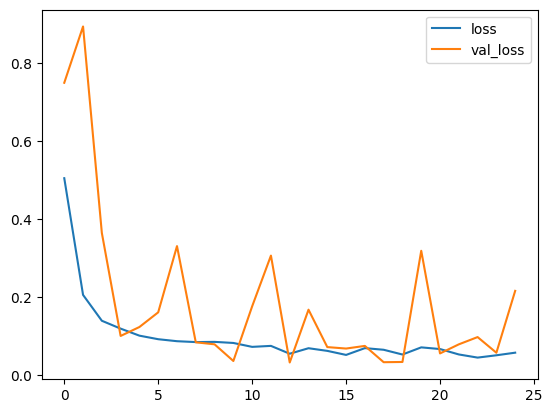

In [20]:

model = load_model('./best_model.h5')
model.save('/content/drive/MyDrive/ENEE719D/Assignment1/best_model.h5')
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

Check test accuracy

In [21]:
model=load_model('/content/drive/MyDrive/ENEE719D/Assignment1/best_model.h5')
model.save(MODEL_TF)
print(MODEL_TF)
y_pred = np.reshape(np.argmax(model.predict(Input_test), axis=1),[len(Input_test),1])
y_true = Label_test

test_acc = float(sum(y_pred == y_true) / len(y_true))
print('Test accuracy is:')
print(f"{test_acc:.2%}")


/content/drive/MyDrive/ENEE719D/Assignment1/models/model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
Test accuracy is:
99.00%


/tmp/ipython-input-3838190036.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_acc = float(sum(y_pred == y_true) / len(y_true))


In [22]:
converter = tf.lite.TFLiteConverter.from_keras_model(keras.models.load_model(MODEL_TF))
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)
def representative_dataset():
  for i in range(500):
    yield([Input_train[i,:,:,:].reshape(1,1,16000,1).astype(np.float32)])

# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(MODEL_TFLITE, "wb").write(model_tflite)



/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 36 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Saved artifact at '/tmp/tmphmew4ont'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1, 16000, 1), dtype=tf.float32, name='input_layer_3')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  133015449646672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133015461001360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133015460999056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133015461000592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133015461000784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133015449645328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133015449646288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133015449644176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133015449648592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133015449644368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1330154496420

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


7592

In [24]:
# Calculate predictions with full software
y_pred = np.reshape(np.argmax(model.predict(Input_test), axis=1),[len(Input_test),1])
y_true = Label_test

test_acc = float(sum(y_pred == y_true) / len(y_true))
print('Test accuracy with model:')
print(f"{test_acc:.2%}")
y_test_pred_no_quant_tflite=np.empty([Input_test.shape[0],1])
y_test_pred_tflite=np.empty([Input_test.shape[0],1])
# Calculate predictions with tensorflow lite
for i in range(0,Input_test.shape[0]):
  y_test_pred_no_quant_tflite[i,0]=np.argmax(predict_tflite(model_no_quant_tflite, Input_test[i:i+1,:,:,:]))

test_acc = float(sum(y_test_pred_no_quant_tflite == y_true) / len(y_true))
print('Test accuracy with model tf lite:')
print(f"{test_acc:.2%}")


# Calculate predictions with tensorflow lite quantized model
for i in range(0,Input_test.shape[0]):
  y_test_pred_tflite[i,0]=np.argmax(predict_tflite(model_tflite, Input_test[i:i+1,:,:,:]))
y_true = Label_test

test_acc = float(sum(y_test_pred_tflite == y_true) / len(y_true))
print('Test accuracy with model quantized:')
print(f"{test_acc:.2%}")





y_test_pred_tflite=np.empty([Input_test.shape[0],2])

# Calculate predictions with tensorflow lite quantized model
for i in range(0,Input_test.shape[0]):
  y_test_pred_tflite[i,:]=(predict_tflite(model_tflite, Input_test[i:i+1,:,:,:]))
y_true = Label_test

y_test_tflite = {"y_test_pred_tflite":y_test_pred_tflite}
sio.savemat('/content/drive/MyDrive/ENEE719D/Assignment1/models/tflite_pred.mat',y_test_tflite)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
Test accuracy with model:
99.00%


/tmp/ipython-input-4275124433.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_acc = float(sum(y_pred == y_true) / len(y_true))
/tmp/ipython-input-4275124433.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_acc = float(sum(y_test_pred_no_quant_tflite == y_true) / len(y_true))


Test accuracy with model tf lite:
99.00%


/tmp/ipython-input-4275124433.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_acc = float(sum(y_test_pred_tflite == y_true) / len(y_true))


Test accuracy with model quantized:
99.25%


Note depending on the model the quantized version might have higher accuracy.

In [27]:
# Calculate size
size_tf_model = os.path.getsize(MODEL_TF)
size_no_quant_tflite = os.path.getsize(MODEL_NO_QUANT_TFLITE)
size_tflite = os.path.getsize(MODEL_TFLITE)

# Compare size
# Compare size
pd.DataFrame.from_records(
    [["TensorFlow", f"{size_tf_model} bytes", ""],
    ["TensorFlow Lite", f"{size_no_quant_tflite} bytes ", f"(reduced by {size_tf_model - size_no_quant_tflite} bytes)"],
     ["TensorFlow Lite Quantized", f"{size_tflite} bytes", f"(reduced by {size_no_quant_tflite - size_tflite} bytes)"]],
     columns = ["Model", "Size", ""], index="Model")

,Size,
Model,,
TensorFlow,76841 bytes,
TensorFlow Lite,10108 bytes,(reduced by 66733 bytes)
TensorFlow Lite Quantized,7592 bytes,(reduced by 2516 bytes)


In [28]:

# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
# Update variable names
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 https://cli.github.com/packages stable InRelease [3,917 B]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:9 https://cli.github.com/packages stable/main amd64 Packages [346 B]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,577 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:14 http:/